In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy matplotlib svgwrite

Note: you may need to restart the kernel to use updated packages.


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision # Import torchvision here


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(grid_im.numpy().astype(np.uint8)) # Use .numpy() for conversion
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())


2.7.1+cu118
11.8
90100


Downloading training dataset

In [6]:
!curl -L -o cat.npy https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: Unknown error (0x80092012) - The revocation function was unable to check revocation for the certificate.


shape: (123202, 784)


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

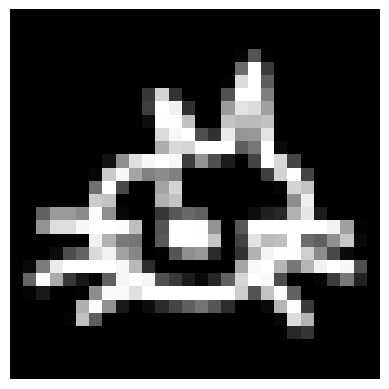

In [8]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('cat.npy')  # shape (N, 784)
print('shape:', data.shape)
img = data[0].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')

In [9]:
from datasets import Dataset



In [10]:
from datasets import Dataset

# Assuming 'data' is your numpy array with shape (N, 784)
# We need to reshape it to (N, 28, 28) and potentially add a channel dimension if needed
# For grayscale images, the shape would be (N, 28, 28, 1)
# If your data is already in the desired image format (H, W, C), you might not need the reshape
reshaped_data = data.reshape(-1, 28, 28)

# Create a dictionary where keys are column names and values are the data arrays
# You can add other columns here if you have labels or other metadata
data_dict = {
    "image": reshaped_data
}

# Create the Dataset
dataset = Dataset.from_dict(data_dict)

print(dataset)

Dataset({
    features: ['image'],
    num_rows: 123202
})


In [11]:
# Split the dataset into training and testing sets
dataset = dataset.train_test_split(test_size=0.1)

# Access the splits
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print("Training dataset:", train_dataset)
print("Testing dataset:", test_dataset)

Training dataset: Dataset({
    features: ['image'],
    num_rows: 110881
})
Testing dataset: Dataset({
    features: ['image'],
    num_rows: 12321
})


In [12]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch # Import torch here
import numpy as np # Import numpy here


# dataset_train = dataset["train"] # This line is no longer needed as we use train_dataset

# dataset = load_dataset("quickdraw", 'full', split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 16

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    # Convert numpy arrays to PIL Images before processing and then stack into a single tensor
    # Explicitly convert each image to a numpy array and ensure it has 3 channels
    images = []
    for image_data in examples["image"]:
        # Ensure the image data is a numpy array and has the correct shape and dtype
        img_array = np.array(image_data, dtype=np.uint8) # Explicitly convert to uint8
        if img_array.ndim == 2: # If grayscale (H, W)
            img_array = np.stack([img_array] * 3, axis=-1) # Convert to (H, W, 3)
        elif img_array.ndim == 3 and img_array.shape[-1] == 1: # If grayscale with channel dim (H, W, 1)
             img_array = np.repeat(img_array, 3, axis=-1) # Convert to (H, W, 3)

        # Convert to PIL Image and then to RGB
        pil_image = Image.fromarray(img_array).convert("RGB")
        images.append(preprocess(pil_image))

    # Stack the list of tensors into a single tensor
    return {"images": torch.stack(images)}

# Apply the transform to the training dataset split
train_dataset.set_transform(transform)


# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

X shape: torch.Size([8, 3, 32, 32])


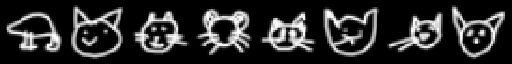

In [13]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [14]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

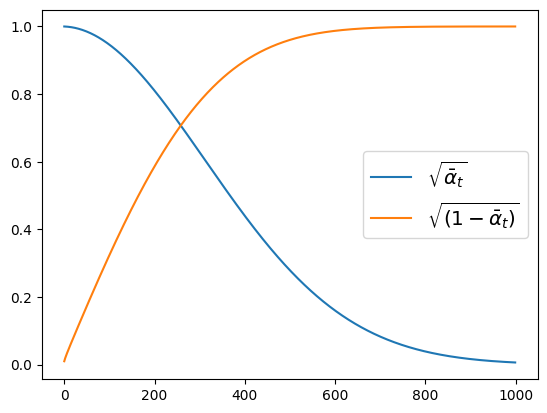

In [15]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [16]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Noisy X shape torch.Size([8, 3, 32, 32])


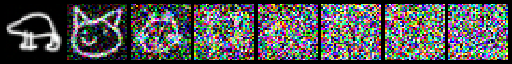

In [17]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [18]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [19]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [20]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
checkpoint_dir = "checkpoints"
import os
os.makedirs(checkpoint_dir, exist_ok=True)

# Check if there's a checkpoint to resume from
latest_checkpoint = None
if os.listdir(checkpoint_dir):
    latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir)], key=os.path.getctime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
else:
    start_epoch = 0


import time
from tqdm import tqdm

# Try smaller batch and enable worker threads in the DataLoader if possible
# (reduce batch_size to 16 or 32 if OOM or very slow)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

for epoch in range(start_epoch, 30):
    epoch_start = time.time()
    # optional: wrap with tqdm to see progress
    for step, batch in enumerate(train_dataloader):
        step_start = time.time()
        clean_images = batch["images"].to(device)

        # sample noise + timesteps
        noise = torch.randn_like(clean_images).to(clean_images.device)
        bs = clean_images.size(0)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # forward
        optimizer.zero_grad()                     # zero grads BEFORE backward
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)

        # backward + step (do not pass loss into backward)
        loss.backward()
        optimizer.step()

        # synchronize and time (accurate for GPU)
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        step_time = time.time() - step_start
        # append and print
        losses.append(loss.item())
        if step % 10 == 0:
            print(f"Epoch {epoch+1} step {step} loss {loss.item():.4f} step_time {step_time:.2f}s")

    print(f"Epoch {epoch+1} finished in {time.time()-epoch_start:.1f}s, avg loss recent {np.mean(losses[-100:]):.4f}")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

Epoch 1 step 0 loss 1.1160 step_time 0.48s
Epoch 1 step 10 loss 0.2345 step_time 0.41s
Epoch 1 step 20 loss 0.1523 step_time 0.42s
Epoch 1 step 30 loss 0.1791 step_time 0.41s
Epoch 1 step 40 loss 0.1568 step_time 0.40s
Epoch 1 step 50 loss 0.1741 step_time 0.43s
Epoch 1 step 60 loss 0.1075 step_time 0.42s
Epoch 1 step 70 loss 0.1039 step_time 0.43s
Epoch 1 step 80 loss 0.0765 step_time 0.41s
Epoch 1 step 90 loss 0.0831 step_time 0.42s
Epoch 1 step 100 loss 0.0666 step_time 0.42s
Epoch 1 step 110 loss 0.0659 step_time 0.41s
Epoch 1 step 120 loss 0.0788 step_time 0.41s
Epoch 1 step 130 loss 0.0588 step_time 0.42s
Epoch 1 step 140 loss 0.0706 step_time 0.41s
Epoch 1 step 150 loss 0.0845 step_time 0.41s
Epoch 1 step 160 loss 0.0721 step_time 0.42s
Epoch 1 step 170 loss 0.0553 step_time 0.42s
Epoch 1 step 180 loss 0.0605 step_time 0.41s
Epoch 1 step 190 loss 0.0612 step_time 0.41s
Epoch 1 step 200 loss 0.0834 step_time 0.41s
Epoch 1 step 210 loss 0.0758 step_time 0.41s
Epoch 1 step 220 loss

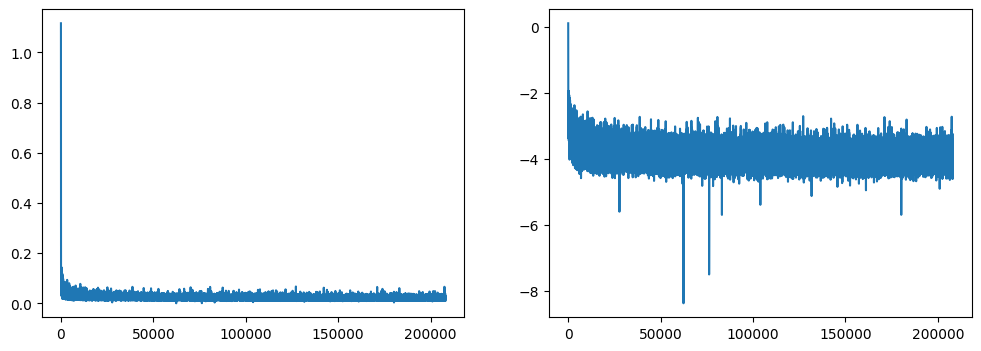

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### Option 1: Creating a pipeline:

In [22]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

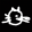

In [23]:
pipeline_output = image_pipe()
pipeline_output.images[0]

We can save a pipeline to a local folder like so:

In [24]:
image_pipe.save_pretrained("my_pipeline")

The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the UNet architecture.

### Option 2: Writing a Sampling Loop

If you inspect the forward method of the pipeline you'll be able to see what is happening when we run `image_pipe()`:

In [ ]:
# ??image_pipe.forward

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

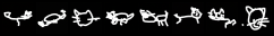

In [30]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.

## Step 7: Push model to the Hub

In the example above we saved our pipeline to a local folder. To push our model to the Hub, we will need to model repository to push our files to. We'll determine the repository name from the model ID we want to give our model (feel free to replace the `model_name` with your own choice; it just needs to contain your username, which is what the function `get_full_repo_name()` does):

In [31]:
from huggingface_hub import get_full_repo_name

model_name = "sd-quick-draw-cats"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'jameswbk/sd-quick-draw-cats'

Next, create a model repository on the 🤗 Hub and push our model:

In [32]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

CommitInfo(commit_url='https://huggingface.co/jameswbk/sd-quick-draw-cats/commit/12c1707dcb552e10b116d101e4c416c1a96edecf', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='12c1707dcb552e10b116d101e4c416c1a96edecf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jameswbk/sd-quick-draw-cats', endpoint='https://huggingface.co', repo_type='model', repo_id='jameswbk/sd-quick-draw-cats'), pr_revision=None, pr_num=None)

The last thing to do is create a nice model card so that our butterfly generator can easily be found on the Hub

In [33]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for the Cat Drawing Diffusion Model (Tech Business Showcase)

This model is a diffusion model for unconditional image generation of cute cat drawings 🐱.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/jameswbk/sd-quick-draw-cats/commit/e139d2e60481a0c6da159b1d779deee6f2038500', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='e139d2e60481a0c6da159b1d779deee6f2038500', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jameswbk/sd-quick-draw-cats', endpoint='https://huggingface.co', repo_type='model', repo_id='jameswbk/sd-quick-draw-cats'), pr_revision=None, pr_num=None)

Now that the model is on the Hub, you can download it from anywhere by using the `from_pretrained()` method of the `DDPMPipeline` as follows"

In [35]:
print(hub_model_id)

jameswbk/sd-quick-draw-cats


In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]